

# Agent-Based Models of Epidemics on Networks

In this set of notes, we'll study several simple models of disease spread on networks. We'll implement and simulate these models using the `mesa` library for agent-based modeling. Then, we'll give an informal derivation of the *epidemic threshold* on networks, which describes the condition under which a disease can spread to a large portion of a networked population.

*This is a set of simulation-driven nodes on agent-based modeling of epidemics on networks. Readers familiar with differential equations and probability generating functions may be interested in consulting the [advanced notes](52-epidemiology.qmd) for a more theoretical discussion of the epidemic threshold and the SIR model.*


## Contact Networks

We're going to consider two simple models of *contact networks*. In a contact network, edges model pathways through infection can spread between two individuals. Real contact networks are *temporal*: interactions occur at a specific point in time, and it is not possible to spread disease outside the time in which the interaction took place. For simplicity, we'll instead model contact networks as static graphs. This can be viewed as an approximation of social life in which we are exposed to the same people over time or every day.

We'll construct two networks on which to run our simulations. By comparing results on these two networks, we'll ask and then give one answer to the question:

> How does the structure of the social contact network influence the spread of disease?

We'll form our two networks as follows:

- For $G_1$, we'll use a power-law distribution to generate expected node degrees.
- For $G_2$, we'll use a Poisson distribution to generate expected node degrees. The Poisson will be tuned to have the same mean degree as the power law.

Once we have the expected node degrees, we'll use the Chung-Lu model to construct the graphs. Here are the degree distributions of the resulting graphs:

In [24]:
!pip install mesa

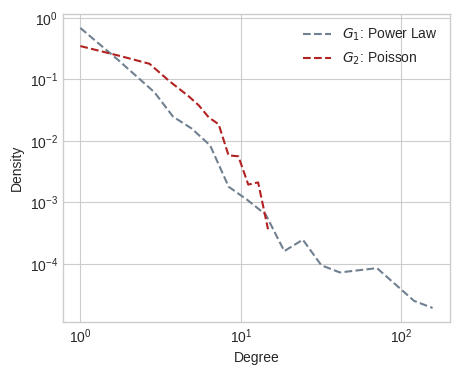

In [25]:
from mesa import Model, Agent                 # core mesa classes
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

alpha = 2 # power law parameter
n = 500   # number of nodes

def degree_sequence(G):
    degrees = nx.degree(G)
    degree_sequence = np.array([deg[1] for deg in degrees])
    return degree_sequence

# form the two degree graphs
power_law_degs = np.random.zipf(alpha, n)
G_1 = nx.expected_degree_graph(power_law_degs, selfloops = False)

# we can get zero-degree nodes through this process; this code ensures that every node has degree at least 1
done = False
while not done:
    degree_seq_G_1 = degree_sequence(G_1)
    zero_deg_nodes = np.where(degree_seq_G_1 == 0)[0]
    node_to_link = np.random.choice(G_1.nodes)
    G_1.add_edge(node_to_link, zero_deg_nodes[0])
    if degree_sequence(G_1).min() > 0:
        done = True

poisson_mean = degree_sequence(G_1).mean()
poisson_degs = np.random.poisson(poisson_mean, n)
G_2 = nx.expected_degree_graph(poisson_degs, selfloops = False)

# plotting degree distributions
def log_binned_histogram(degree_sequence, interval = 5, num_bins = 20):
    nonzero = degree_sequence[degree_sequence > 0]

    hist, bins = np.histogram(nonzero, bins = min(int(len(nonzero)/interval), num_bins))
    bins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    hist, bins = np.histogram(nonzero, bins = bins)
    binwidths = bins[1:] - bins[:-1]
    hist = hist / binwidths
    p = hist/hist.sum()

    return bins[:-1], p

fig, ax = plt.subplots(1, 1, figsize = (5, 4))

for i in range(2):
    G = [G_1, G_2][i]
    color = ["slategrey", "firebrick"][i]
    deg_seq = degree_sequence(G)
    x, p = log_binned_histogram(deg_seq, interval = 5, num_bins = 20)
    ix = p > 0

    ax.plot(x[ix], p[ix],  label = [r"$G_1$: Power Law", r"$G_2$: Poisson"][i], linestyle = "--", color = color)
    ax.loglog()
    ax.set_xlabel("Degree")
    ax.set_ylabel("Density")
    ax.legend()

## Compartmental Modeling

Now that we have our structure in place, it's time to set the dynamics of the model. We are going to use the common framework of *compartmental modeling*. In compartmental models, each agent can be in one of several discrete *compartments*. These compartments represent the possible states in which an agent can exist. For example, in the **SI** model, there are two compartments: **S**usceptible and **I**nfected. In the **SIR** model, there are three compartments: **S**usceptible, **I**nfected, and **R**ecovered.

A model framework can be specified at a high level by describing the compartments which exist as well as the rules by which agents move between states.

In the models that we consider here, we'll usually assume a **S**usceptible population. We'll assume that one individual ("Patient Zero") starts out **I**nfected, and then track the course of the disease over time.

## Implementation in Mesa

We'll implement our epidemic models using the `mesa` library. The `CompartmentalModel` with that we introduced last time for modeling opinion dynamics with the voter model will also work for epidemic modeling with just a few minor tweaks. The main work is to define new agents with new states and transitions.[In the [advanced notes](52-epidemiology.qmd) on the theory of epidemiology on graphs, you can learn more about how things look if we assume that infection takes place in continuous rather than discrete time.]{.aside} One small wrinkle is that this time we will use *synchronous* updating, in which each node performs its update simultaneously. This involves adding a second method (`advance`) to each agent; the `step` method will compute the new state of the node and the `advance` method will save it as the new current state.

In [26]:
class CompartmentalModel(Model):

    # model setup
    def __init__(self, G, agent_class, infection_rate = 0.1, recovery_rate = None):

        super().__init__()
        self.grid = NetworkGrid(G)
        self.infection_rate = infection_rate
        self.recovery_rate = recovery_rate

        # populate the graph
        for node in list(G.nodes):
            state = "S"
            agent = agent_class(self, state)
            self.grid.place_agent(agent, node)

        # track the states of each agent over time
        self.collector = DataCollector(
            agent_reporters = {
                "state" : lambda a: a.state
            }
        )

        # seed infected individual
        self.seed_infection()

    # pick a single agent uniformly at random who will start out infected
    def seed_infection(self):
        patient_zero = np.random.choice(self.grid.agents)
        patient_zero.state = "I"
        self.collector.collect(self)

    def step(self):
        self.agents.do("step")
        self.agents.do("advance")
        self.collector.collect(self)

It now remains to specify the compartmental dynamics, which we do in the `Agent` class.  

## The SI Model

In the SI model, agents can be in one of two states: *susceptible* (S) or *infected* (I). Infected agents can infect their neighbors, and once an agent is infected, they are infected forever. The *state diagram* for the SI model looks like this:

```{mermaid}
graph LR
    S -->|infection| I;
```

There are many ways to implement this general idea. For our implementation, we'll just assume that in each timestep, an agent has probability $p$ to be infected by each of their infected neighbors independently. This means that the probability of an agent being infected in a given timestep is $1 - (1-p)^k$, where $k$ is the number of infected neighbors. It is also possible to implement this update simply by looping through the neighbors and making updates depending on their states.

In [29]:
class SIAgent(Agent):
    def __init__(self, model, state):
        super().__init__(model)
        self.state = state
        self.new_state = self.state

    def get_infected(self):

        neighbors = self.model.grid.get_neighbors(self.pos,
                                                include_center = False)

        self.new_state = self.state
        for neighbor in neighbors:
            if neighbor.state == "I":
                if np.random.rand() < self.model.infection_rate:
                    self.new_state = "I"

    # compute what the new state will be
    def step(self):
        if self.state == "S":
            self.get_infected()
        elif self.state == "I":
            pass

    # save the new state as the next current state
    def advance(self):
        self.state = self.new_state

First, let's look at the progress of our simulation in a small, simple network:

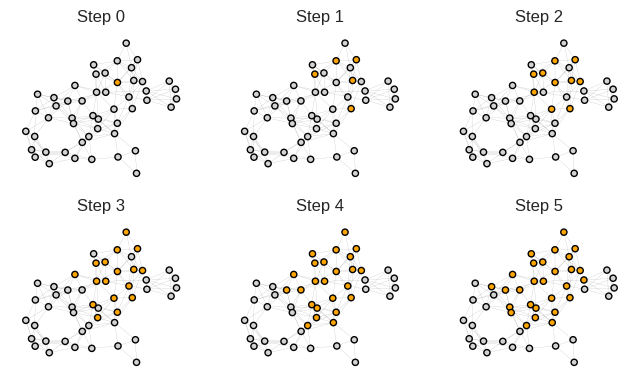

In [31]:
np.random.seed(1234)
G = nx.random_geometric_graph(50, 0.25)
pos = nx.kamada_kawai_layout(G)

sim = CompartmentalModel(G, SIAgent, infection_rate = 0.2)

fig, axarr = plt.subplots(2, 3, figsize = (8, 4.5))

state_colors = {
    "S" : "lightgrey",
    "I" : "orange",
    "R" : "steelblue"
}

for i in range(6):
    ax = axarr.ravel()[i]
    sim.step()
    states = sim.collector.get_agent_vars_dataframe()
    colors = [state_colors[s] for s in states.loc[i].values.ravel()]
    nx.draw(G, pos, node_color = colors, ax = ax, node_size = 20, edge_color = "grey", width = 0.1, edgecolors = "black")
    ax.set(title = f"Step {i}", xticks = [], yticks = [])

How representative is this visualization? Would we see something similar on our two model networks $G_1$ and $G_2$? To address these questions, let's define a function to run the simulation on a specified network and compute the total number of agents in each compartment over time:

In [32]:
def epi_experiment(G, agent_type, timesteps, infection_rate, ax, recovery_rate = None, label = True, **kwargs):

    # initialize and run the model
    sim = CompartmentalModel(G, agent_type, infection_rate = infection_rate, recovery_rate = recovery_rate)
    for _ in range(timesteps):
        sim.step()

    # gather counts of states over time
    df = sim.collector.get_agent_vars_dataframe()
    counts = df.groupby(["Step", "state"]).size().unstack().fillna(0)
    proportions = counts / counts.sum(axis = 1).values[:, None]

    # plotting
    states = list(proportions.columns)


    for i, state in enumerate(["I", "R"]):
        if state in proportions.columns:
            if label:
                ax.plot(proportions[state], label = state, color = state_colors[state], **kwargs)
            else:
                ax.plot(proportions[state], color = state_colors[state], **kwargs)

    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Agents")
    ax.set(ylim = (-0.02, 1.02))
    ax.legend()
    return ax

Now we can run simulations and plot the total number of infected nodes like this:

<Axes: xlabel='Time', ylabel='Number of Agents'>

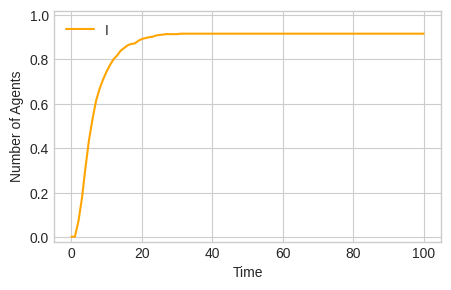

In [34]:
timesteps = 100
fig, ax = plt.subplots(1, 1, figsize = (5, 3))
infection_rate = 0.2

epi_experiment(G_1, SIAgent, timesteps, infection_rate = infection_rate, ax = ax)

After an initial quiet period, the disease rapidly takes over a large fraction of the population.

Is this typical behavior? Let's run 20 simulations on both graphs and compare:

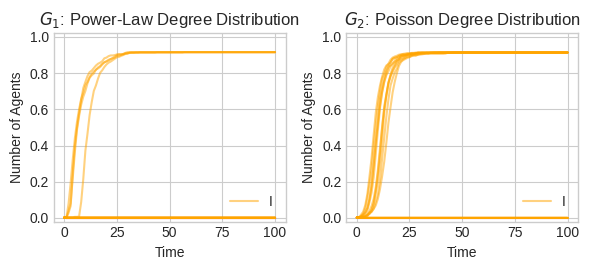

In [35]:

fig, ax = plt.subplots(1, 2, figsize = (6, 2.8))

for i in range(20):
    epi_experiment(G_1, SIAgent, timesteps, infection_rate = infection_rate,   ax = ax[0], alpha = 0.5, label = i == 0)
    epi_experiment(G_2, SIAgent, timesteps, infection_rate = infection_rate,   ax = ax[1], alpha = 0.5, label = i == 0)
ax[0].set(title = r"$G_1$: Power-Law Degree Distribution")
ax[1].set(title = r"$G_2$: Poisson Degree Distribution")

plt.tight_layout()

Several features stand out:

1. The disease does not inevitably take over the entirety of $G_1$: in some cases, it seems that only very few agents are infected, while in others a very large fraction of the population (but not the entire population) is infected.
2. It appears that the disease tends to work its way slightly more quickly thorough $G_1$ and $G_2$. An interesting qualitative feature is the apparent explosive growth in the infection rate from a seeming period of calm in $G_1$. In $G_2$, on the other hand, the increase in infection is somewhat more gradual.

::: {.callout-important}

## Exercise

Can you explain observation 1? What determines the final size of the epidemic?

*Hint*: think about the initial condition and the graph structure.

:::



## The SIR Model

Now we'll suppose that agents can also *recover* from infection. A recovered (R) agent is no longer susceptible to disease and can therefore never become infected again. The corresponding state diagram looks like this:

```{mermaid}
graph LR
    S -->|infection| I -->|recovery| R;
```

In most implementations of the SIR model, the recovery rate does not depend on the status of one's neighbors: an infected node simply becomes recovered with some fixed probability each day. Once an agent is recovered, they are considered to be immune and no longer susceptible to infection. To implement this behavior, we just need to implement a `recover` method and lightly modify the `step` method to incorporate recovery. We can save a few lines of code by inheriting from the previous `SIAgent` class.

In [36]:
class SIRAgent(SIAgent):

  def recover(self):
    if np.random.random() < self.model.recovery_rate:
      self.new_state = "R"

  def step(self):
    if self.state == "S":
      self.get_infected()

    elif self.state == "I":
      self.recover()

Now there are three states that an agent could have at any given time. The evolution of the disease states now looks more like this:

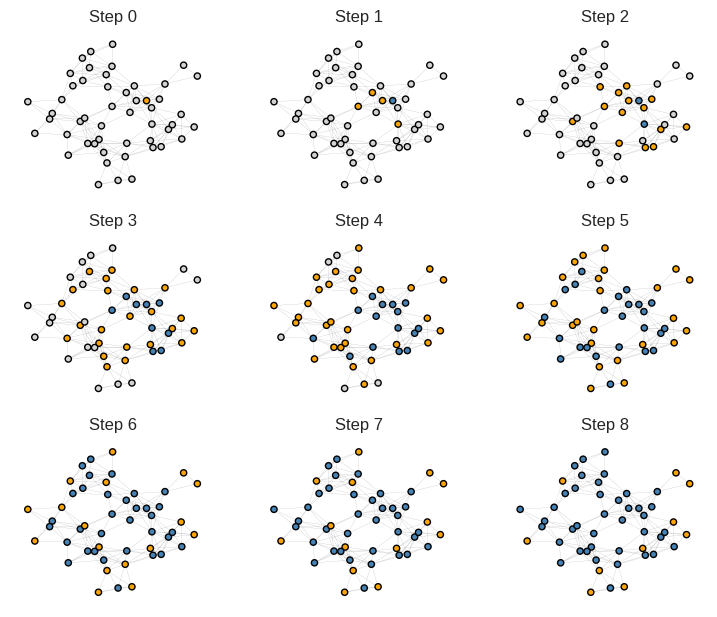

In [37]:

np.random.seed(1234)
G = nx.random_geometric_graph(50, 0.25)
# pos = nx.fruchterman_reingold_layout(G)
pos = nx.kamada_kawai_layout(G)

sim = CompartmentalModel(G, SIRAgent, infection_rate = 0.5, recovery_rate = 0.3)

fig, axarr = plt.subplots(3, 3, figsize = (9, 7.5))

for i in range(9):
    ax = axarr.ravel()[i]
    sim.step()
    states = sim.collector.get_agent_vars_dataframe()
    colors = [state_colors[s] for s in states.loc[i].values.ravel()]
    nx.draw(G, pos, node_color = colors, ax = ax, node_size = 20, edge_color = "grey", width = 0.1, edgecolors = "black")
    ax.set(title = f"Step {i}", xticks = [], yticks = [])

Over time, Infected nodes become Recovered, after which they cannot become Infected again. This causes the disease to travel across the graph, leaving groups of Recovered nodes in its wake.

Let's now do a batch experiment in which we observe the proportion of both Infected and Recovered individuals over many simulation runs. We'll choose a recovery rate corresponding to an average illness duration of approximately two weeks.

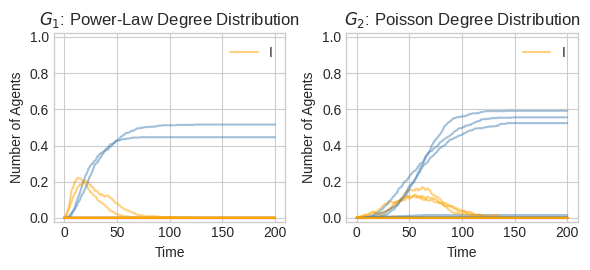

In [38]:
infection_rate = 0.04
recovery_rate = 1/14

timesteps = 200
fig, ax = plt.subplots(1, 2, figsize = (6, 2.8))
for i in range(20):
    epi_experiment(G_1, SIRAgent, timesteps, infection_rate = infection_rate, recovery_rate = recovery_rate, ax = ax[0], alpha = 0.5, label = i == 0)
    epi_experiment(G_2, SIRAgent, timesteps, infection_rate = infection_rate, recovery_rate = recovery_rate, ax = ax[1], alpha = 0.5, label = i == 0)

ax[0].set_title(r"$G_1$: Power-Law Degree Distribution")
ax[1].set_title(r"$G_2$: Poisson Degree Distribution")

plt.tight_layout()

Here we can observe an interesting difference between the two network substrates:

- In the power law graph $G_1$, the disease spreads rapidly in an early initial phase before dying out.
- In the Poisson graph $G_2$ on the other hand, the disease spreads more slowly through the population. In at least some simulations, however, the disease ultimately infects a larger fraction of individuals.

There is an even more striking difference between the two models when the infection rate is lower:


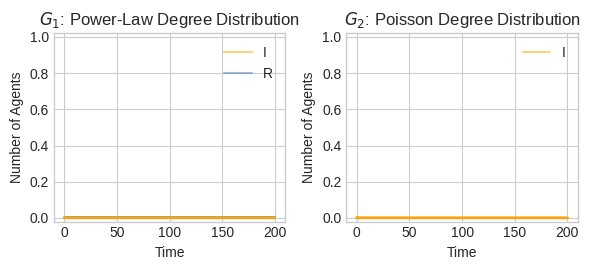

In [40]:
infection_rate = 0.015
timesteps = 200
fig, ax = plt.subplots(1, 2, figsize = (6, 2.8))
for i in range(20):
    epi_experiment(G_1, SIRAgent, timesteps, infection_rate = infection_rate, recovery_rate = recovery_rate, ax = ax[0], alpha = 0.5, label = i == 0)
    epi_experiment(G_2, SIRAgent, timesteps, infection_rate = infection_rate, recovery_rate = recovery_rate, ax = ax[1], alpha = 0.5, label = i == 0)

ax[0].set_title(r"$G_1$: Power-Law Degree Distribution")
ax[1].set_title(r"$G_2$: Poisson Degree Distribution")

plt.tight_layout()

Whereas in the Poisson random graph $G_2$ large outbreaks are rare and relatively slow-moving, in the power law graph $G_1$ we see that large outbreaks are possible and rip through the population much faster.

## Theory: What's Going On?

How can we explain the difference in behaviors between epidemic outbreaks on these two contact networks? The mean degree in these networks is relatively similar:

In [42]:
mean_deg_1 = degree_sequence(G_1).mean()
mean_deg_2 = degree_sequence(G_2).mean()

print(f"Mean degree of G_1:  {mean_deg_1:.2f}")
print(f"Mean degree of G_2:  {mean_deg_2:.2f}")

Mean degree of G_1:  3.69
Mean degree of G_2:  3.81


So, it's not the case that $G_1$ is "more connected on average" than $G_2$. Instead, we need to ask questions about *how* these two networks are connected.

Let's do some simple heuristic reasoning to understand the connectivity difference. [For a more theoretically rich discussion, see the [advanced nodes](52-epidemiology.qmd)]{.aside}. The question we'll consider is: in expectation, how many infections are caused by each infectious agent before they recover? This is sometimes called the *basic reproduction number* of the disease, and is denoted by $R_0$. If $R_0 < 1$, we expect the disease to die out quickly, while if $R_0 > 1$, we expect the disease to spread exponentially through the population.

Here's a first attempt to derive $R_0$. Let $\beta$ be the probability that transmission occurs from an infected agent to a susceptible neighbor in a given timestep. The average amount of time that an individual spends infectious is $1/\gamma$, where $\gamma$ is the recovery rate per day. Assuming that $\beta$ is relatively small, the probability that an infected individual passes the disease to a given susceptible neighbor before recovering is approximately $\beta/\gamma$.

So, if Patient 0 is node $i$, then the expected number of infections caused directly by Patient 0 before they recover is $\theta_i = \beta/\gamma k_i$, where $k_i$ is the degree of node $i$. If $\theta_i \geq 1$, then, on average, Patient 0 will infect at least one of their neighbors before recovering. Averaging over all possible initial nodes $i$, we derive our first attempt to measure $R_0$:
$$
\begin{aligned}
    R_0 \stackrel{?}{=} \langle \theta_i \rangle = \frac{\beta}{\gamma} \langle k_i \rangle = \frac{\beta}{\gamma} \langle k \rangle
\end{aligned}
$$

Let's compute this measure for each of our graphs:

In [43]:
r_1 = degree_sequence(G_1).mean() * infection_rate / recovery_rate
r_2 = degree_sequence(G_2).mean() * infection_rate / recovery_rate

print(f"beta/gamma * <k> in G_1:  {r_1:.2f}")
print(f"beta/gamma * <k> in G_2:  {r_2:.2f}")

beta/gamma * <k> in G_1:  0.77
beta/gamma * <k> in G_2:  0.80


The two graphs have very similar values of the measure $ \frac{\beta}{\gamma} \langle k \rangle$, which makes sense since this measure differs between the two graphs only in the mean degree $\langle k \rangle$, which we intentionally made similar between the graphs.

To explain the difference, we need to return to our discussion of [graphs with fixed degree distributions](11-configuration-models.qmd). The number of neighbors of Patient 0 is distributed according to the degree distribution $p_k$ of the graph, and the mean is $\langle k \rangle$. However, the number of neighbors *of those neighbors* is not distributed according to $p_k$. Instead, as we saw when discussing graphs with fixed degree distribution, the distribution $q_k$ of the number of neighbors attached to a node (excluding the edge we traveled along to get there) is given by the formula [As a refresher, the intuition here is that for the node to have $k$ neighbors (excluding the edge we traveled on) it must have total degree $k+1$. The probability that a given node has this degree is $p_{k+1}$ and there are $k+1$ ways to travel to that node along an edge. The $\langle k \rangle$ in the denominator is for normalization.]{.aside}

$$
\begin{aligned}
    q_k = \frac{(k+1)p_{k+1}}{\langle k \rangle }\;.
\end{aligned}
$$

So, the expected number of neighbors of a node in the second generation of infection is

$$
\begin{aligned}
    \sum_{k = 0}^\infty k q_k &= \sum_{k = 0}^\infty k \frac{(k+1)p_{k+1}}{\langle k \rangle} \\
    &= \frac{1}{\langle k \rangle} \sum_{k' = 1}^\infty (k'-1) k'p_{k'} &\quad \text{(Let $k' = k+1$)} \\
    &= \frac{1}{\langle k \rangle} \sum_{k' = 0}^\infty (k'-1) k'p_{k'} \\
    &= \frac{\langle k^2 \rangle - \langle k \rangle}{\langle k \rangle}
\end{aligned}
$$

This corresponds to an expected number of infections given by

$$
\begin{aligned}
    R_0 = \frac{\beta}{\gamma} \frac{\langle k^2 \rangle - \langle k \rangle}{\langle k \rangle}
\end{aligned}
$${#eq-R0}

Let's measure this for each of our two graphs:

In [44]:
def mean_excess_degree(G):
    k = degree_sequence(G)
    mean_k = k.mean()
    mean_k_2 = (k**2).mean()
    return (mean_k_2 - mean_k) / mean_k

R0_1 = infection_rate / recovery_rate * mean_excess_degree(G_1)
R0_2 = infection_rate / recovery_rate * mean_excess_degree(G_2)

print(f"<k^2> in G_1:  {R0_1:.2f}")
print(f"<k^2> in G_2:  {R0_2:.2f}")

<k^2> in G_1:  9.64
<k^2> in G_2:  1.02


Now we can see a clearer difference between the two graph structures: $R_0$ in $G_1$ is indeed sufficient to support initial exponential growth of the outbreak, while $R_0$ in $G_2$ is not.

@eq-R0 can be used to make predictions about when a disease has the capability to spread in a contact network. Note the condition $R_0$ does not *guarantee* that large-scale spread will occur, but does indicate risk.

[An interesting consequence of @eq-R0 is that a theoretical network in which $\langle k^2 \rangle = \infty$" (i.e. the sum $\sum_{k}k^2 p_k$ does not converge) *always* admits wide-scale spread of disease, no matter how transmissible the disease is or how quickly agents recover. Another way to say this is that the *epidemic threshold*, which is the critical value of the ratio $\frac{\beta}{ \gamma}$ that admits large-scale spread, is $0$.]{.aside}

Intuitively, what is happening here is that there are a small number of nodes in $G_1$ with *very* high degree. In the event that one of these nodes is infected, they have a large number of neighbors to which they may transmit disease. Even if the disease has a low transmission rate, the sheer number of people who come into contact with these nodes ensures spread. Such nodes are often called *super-spreaders*. A simple way to describe the difference between $G_1$ and $G_2$ is that $G_1$ has super-spreaders while $G_2$ does not.